In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split
import shutil
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import math
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Function to load and split data
def load_and_split_data(dataset_dir, classes):
    all_data = []
    for dataset_type in ['train', 'test']:
        for class_name in classes:
            class_dir = os.path.join(dataset_dir, dataset_type, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                all_data.append((img_path, class_name))

    df = pd.DataFrame(all_data, columns=['path', 'class'])
    train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
    validation_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)
    return train_data, validation_data, test_data

# Function to create directories
def create_directories(directory, classes):
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        os.makedirs(class_path, exist_ok=True)

# Function to copy data
def copy_data(data, destination_dir):
    for index, row in data.iterrows():
        img_path = row['path']
        img_name = os.path.basename(img_path)
        class_name = row['class']
        destination_path = os.path.join(destination_dir, class_name, img_name)
        shutil.copy(img_path, destination_path)

# Load and split the data
dataset_dir = '/kaggle/input/covid19-image-dataset/Covid19-dataset'
classes = ['Covid', 'Normal', 'Viral Pneumonia']
train_data, validation_data, test_data = load_and_split_data(dataset_dir, classes)

# Define directories for the new split
new_dataset_dir = '/kaggle/working/split_dataset'
train_dir = os.path.join(new_dataset_dir, 'train')
validation_dir = os.path.join(new_dataset_dir, 'validation')
test_dir = os.path.join(new_dataset_dir, 'test')

# Create directories for the new split
create_directories(new_dataset_dir, classes)
create_directories(train_dir, classes)
create_directories(validation_dir, classes)
create_directories(test_dir, classes)

# Copy data to the new split
copy_data(train_data, train_dir)
copy_data(validation_data, validation_dir)
copy_data(test_data, test_dir)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load your dataset using the new split
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(320, 320),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(320, 320),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 219 images belonging to 3 classes.
Found 64 images belonging to 3 classes.


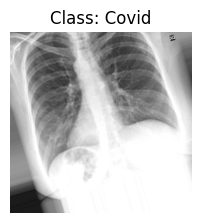

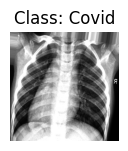

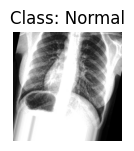

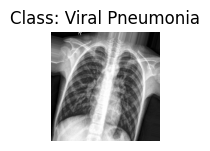

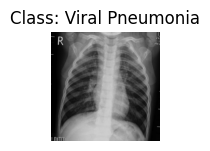

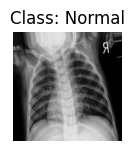

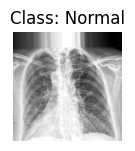

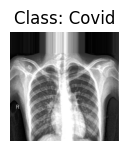

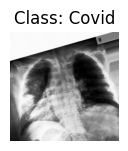

In [3]:
import matplotlib.pyplot as plt
# Display some training images
plt.figure(figsize=(12, 8))

# Create a mapping from class numbers to class names
class_names = {v: k for k, v in train_generator.class_indices.items()}

for i in range(9):  # Change the number of images you want to display
    image, label = train_generator.next()  # Get the next batch of images and labels
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    class_num = label[i].argmax()
    class_name = class_names[class_num]
    plt.title(f'Class: {class_name}')
    plt.axis('off')
    plt.show()



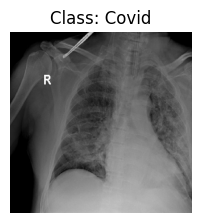

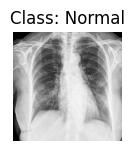

In [4]:
# Display some validation images
plt.figure(figsize=(12, 8))
# Create a mapping from class numbers to class names
class_names = {v: k for k, v in train_generator.class_indices.items()}

for i in range(2):  # Change the number of images you want to display
    image, label = val_generator.next()  # Get the next batch of images and labels
    plt.subplot(3, 2, i + 1)
    plt.imshow(image[0])
    class_num = label[i].argmax()
    class_name = class_names[class_num]
    plt.title(f'Class: {class_name}')
    plt.axis('off')
    plt.show()


In [5]:
# Model Architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(3, activation='softmax')(x)  # Adjust NUM_CLASSES to your task

model = Model(inputs=base_model.input, outputs=predictions)




In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15
7/7 [==============================] - 15s 2s/step - loss: 1.1045 - accuracy: 0.4429 - val_loss: 0.9448 - val_accuracy: 0.4375
Epoch 2/15
7/7 [==============================] - 10s 1s/step - loss: 0.8885 - accuracy: 0.5388 - val_loss: 0.7681 - val_accuracy: 0.6875
Epoch 3/15
7/7 [==============================] - 10s 2s/step - loss: 0.6615 - accuracy: 0.7900 - val_loss: 0.6622 - val_accuracy: 0.7656
Epoch 4/15
7/7 [==============================] - 10s 1s/step - loss: 0.5810 - accuracy: 0.8128 - val_loss: 0.5769 - val_accuracy: 0.7656
Epoch 5/15
7/7 [==============================] - 10s 1s/step - loss: 0.5037 - accuracy: 0.8493 - val_loss: 0.5271 - val_accuracy: 0.7812
Epoch 6/15
7/7 [==============================] - 10s 1s/step - loss: 0.4228 - accuracy: 0.8813 - val_loss: 0.4771 - val_accuracy: 0.8438
Epoch 7/15
7/7 [==============================] - 10s 1s/step - loss: 0.3754 - accuracy: 0.9224 - val_loss: 0.4448 - val_accuracy: 0.8438
Epoch 8/15
7/7 [==================

In [9]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [10]:
## Fine tuning to improve accuracy 
import keras

fine_tune_at = 120
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks= [early_stopping]
    )

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 0.1933 - accuracy: 0.9589 - val_loss: 0.3155 - val_accuracy: 0.8750
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.2184 - accuracy: 0.9361 - val_loss: 0.3047 - val_accuracy: 0.8906
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.2001 - accuracy: 0.9589 - val_loss: 0.3019 - val_accuracy: 0.8750
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.2033 - accuracy: 0.9498 - val_loss: 0.2996 - val_accuracy: 0.8750
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.1771 - accuracy: 0.9543 - val_loss: 0.2994 - val_accuracy: 0.8906
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.1971 - accuracy: 0.9452 - val_loss: 0.2882 - val_accuracy: 0.8906
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.1761 - accuracy: 0.9498 - val_loss: 0.2855 - val_accuracy: 0.8906


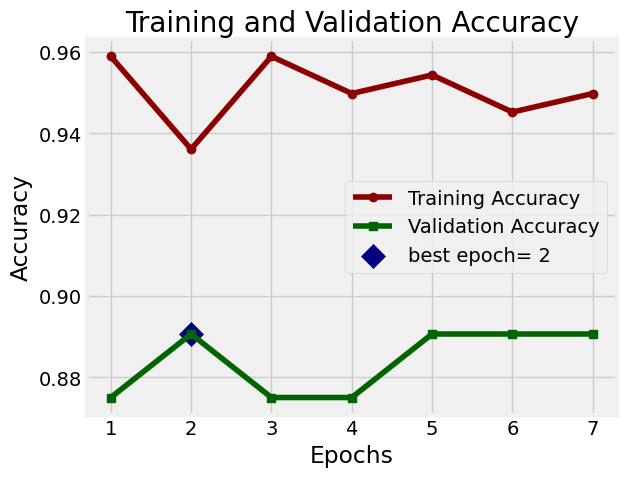

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history with custom styles
plt.figure(figsize=(12, 5))
plt.style.use('fivethirtyeight')

# Define acc_label here
acc_label = f'best epoch= {str(index_acc + 1)}'  # Adjust here to display 1-based epoch

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, linestyle='-', color='darkred', marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, linestyle='-', color='darkgreen', marker='s', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='navy', marker='D', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

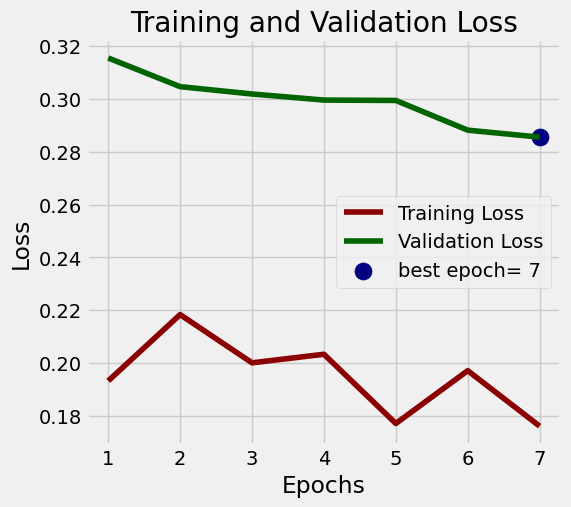

In [12]:
# Training and Validation Loss plot

# Define needed variables
tr_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history with custom styles
plt.figure(figsize=(12, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, linestyle='-', color='darkred', label='Training Loss')
plt.plot(Epochs, val_loss, linestyle='-', color='darkgreen', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='navy', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [13]:


# Modeli fine-tune ile eğit
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Modeli kaydet (isteğe bağlı)
model.save("/kaggle/working/fine_tuned_model.h5")

# Modeli test et
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(320, 320),
    batch_size=32,
    shuffle=False,  # Doğru değerlendirme için shuffle'ı False yapın
    class_mode='categorical'
)

# Modeli test seti üzerinde değerlendir
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
7/7 [==============================] - 11s 2s/step - loss: 0.1951 - accuracy: 0.9452 - val_loss: 0.2996 - val_accuracy: 0.8750
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.1634 - accuracy: 0.9589 - val_loss: 0.2996 - val_accuracy: 0.8594
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 0.1787 - accuracy: 0.9635 - val_loss: 0.2919 - val_accuracy: 0.8906
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.1664 - accuracy: 0.9726 - val_loss: 0.2881 - val_accuracy: 0.8906
Epoch 5/10
7/7 [==============================] - 10s 1s/step - loss: 0.1614 - accuracy: 0.9589 - val_loss: 0.2833 - val_accuracy: 0.8906
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.1581 - accuracy: 0.9772 - val_loss: 0.2794 - val_accuracy: 0.8906
Epoch 7/10
7/7 [==============================] - 10s 1s/step - loss: 0.1744 - accuracy: 0.9543 - val_loss: 0.2756 - val_accuracy: 0.8906
Epoch 8/10
7/7 [==================

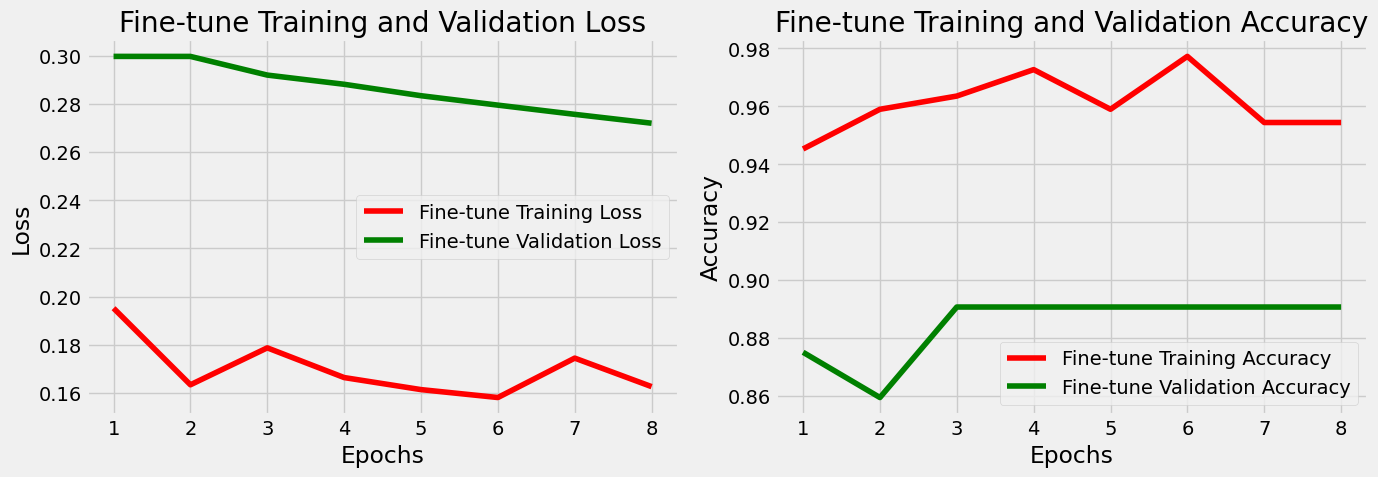

In [14]:
# Fine-tune ile eğitilen modelin eğitim geçmişi
fine_tune_epochs = len(history.history['accuracy'])
fine_tune_epochs_range = range(1, fine_tune_epochs + 1)

# Eğitim ve doğrulama (validation) loss değerleri
fine_tune_train_loss = history.history['loss']
fine_tune_val_loss = history.history['val_loss']

# Eğitim ve doğrulama (validation) accuracy değerleri
fine_tune_train_acc = history.history['accuracy']
fine_tune_val_acc = history.history['val_accuracy']

# Grafik çizimi
plt.figure(figsize=(14, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(fine_tune_epochs_range, fine_tune_train_loss, 'r', label='Fine-tune Training Loss')
plt.plot(fine_tune_epochs_range, fine_tune_val_loss, 'g', label='Fine-tune Validation Loss')
plt.title('Fine-tune Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(fine_tune_epochs_range, fine_tune_train_acc, 'r', label='Fine-tune Training Accuracy')
plt.plot(fine_tune_epochs_range, fine_tune_val_acc, 'g', label='Fine-tune Validation Accuracy')
plt.title('Fine-tune Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()